In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(7)

In [2]:
# Simple Baseline constants
m_ball = 0.058  # kg (tennis ball)
v_in = 30.0     # m/s incoming ball speed
e_base = 0.45   # baseline COR proxy

L = 0.685       # racket length (m)
x_handle = 0.10 # handle reference point (m) for "shock"

In [3]:
# Simple physics helpers

def clamp(a, lo, hi):
    return np.minimum(np.maximum(a, lo), hi)

def effective_mass_at_impact(m_racket, x_norm):
    """
    Effective mass increases as you move from handle to head.
    x_norm: 0 at handle, 1 at tip.
    """
    # handle feels "lighter", head feels "heavier"
    r_min, r_max = 0.12, 0.35
    ratio = r_min + (r_max - r_min) * (x_norm ** 0.8)
    return ratio * m_racket

def exit_speed_proxy(v_in, m_eff, m_ball, e):
    """
    Simple 1D impact proxy (ball rebound speed).
    """
    return (1 + e) * (m_eff / (m_eff + m_ball)) * v_in

def mode_shape_1(x_norm):
    """
    Very simple 1st bending mode shape proxy along the racket length.
    Zero-ish near handle, peak near tip.
    """
    return np.sin(np.pi * x_norm)

def mode_shape_2(x_norm):
    """
    Simple 2nd mode proxy.
    """
    return np.sin(2 * np.pi * x_norm)

def vibration_score(x_norm, k_string, damping, m_racket):
    """
    Proxy for vibration/shock felt after impact.
    - Higher string stiffness generally increases high-frequency content.
    - More damping reduces vibration.
    - Impact near handle reduces vibration at handle.
    """
    phi1 = mode_shape_1(x_norm)
    phi2 = mode_shape_2(x_norm)

    # energy injected into modes
    injected = (phi1**2 + 0.6 * phi2**2)

    # stiffer strings -> more impulse-like response (proxy)
    stiffness_factor = (k_string / 3000.0) ** 0.35

    # damping reduces vibration
    damp_factor = 1.0 / (1.0 + 8.0 * damping)

    # heavier racket tends to reduce vibration amplitude a bit
    mass_factor = (0.32 / m_racket) ** 0.25

    return injected * stiffness_factor * damp_factor * mass_factor

In [4]:
# Design variables

N = 7000

# Racket mass (kg)
m_racket = np.random.uniform(0.285, 0.340, size=N)

# String stiffness proxy (N/m)
k_string = np.random.uniform(2200, 4200, size=N)

# Damping ratio proxy (dimensionless)
damping = np.random.uniform(0.01, 0.08, size=N)

# Impact location along length (0=handle, 1=tip)
x_norm = np.random.uniform(0.15, 0.95, size=N)

# COR depends on string stiffness a bit (very mild)
e = e_base + 0.08 * (k_string - 3000) / 1200
e = clamp(e, 0.35, 0.55)

In [5]:
# outputs for each design

m_eff = effective_mass_at_impact(m_racket, x_norm)
v_exit = exit_speed_proxy(v_in, m_eff, m_ball, e)

vib = np.array([vibration_score(xn, ks, d, mr) for xn, ks, d, mr in zip(x_norm, k_string, damping, m_racket)])

# handle shock proxy: impact closer to handle + higher vibration -> more shock
# distance factor: farther from handle generally increases torque/shock
dist_factor = (x_norm - (x_handle / L))
dist_factor = clamp(dist_factor, 0.0, 1.0)

shock = vib * (0.55 + 0.9 * dist_factor)

df = pd.DataFrame({
    "m_racket": m_racket,
    "k_string": k_string,
    "damping": damping,
    "x_norm": x_norm,
    "e": e,
    "m_eff": m_eff,
    "v_exit": v_exit,
    "vibration": vib,
    "shock_proxy": shock
})

df.head()

,m_racket,k_string,damping,x_norm,e,m_eff,v_exit,vibration,shock_proxy
0,0.289197,3594.279883,0.058610,0.683777,0.489619,0.083778,26.406886,0.895630,0.926093
1,0.327896,2362.305349,0.031204,0.176295,0.407487,0.058160,21.141455,0.553714,0.319648
2,0.309113,2526.920220,0.042492,0.634289,0.418461,0.086488,25.471930,0.827484,0.818774
3,0.324791,2973.524774,0.020636,0.460204,0.448235,0.079125,25.070228,0.870536,0.724980
4,0.338789,2622.409395,0.068929,0.800238,0.424827,0.105853,27.614146,0.537684,0.612329


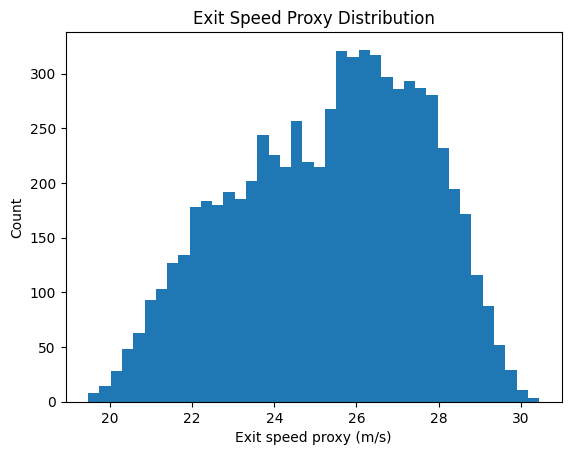

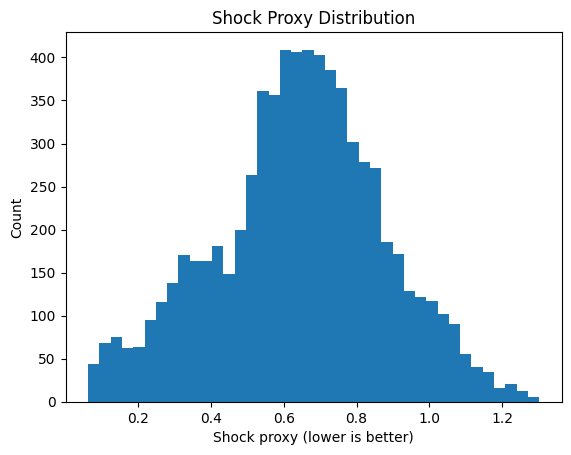

In [6]:
# Quick distributions

plt.figure()
plt.hist(df["v_exit"], bins=40)
plt.xlabel("Exit speed proxy (m/s)")
plt.ylabel("Count")
plt.title("Exit Speed Proxy Distribution")
plt.show()

plt.figure()
plt.hist(df["shock_proxy"], bins=40)
plt.xlabel("Shock proxy (lower is better)")
plt.ylabel("Count")
plt.title("Shock Proxy Distribution")
plt.show()

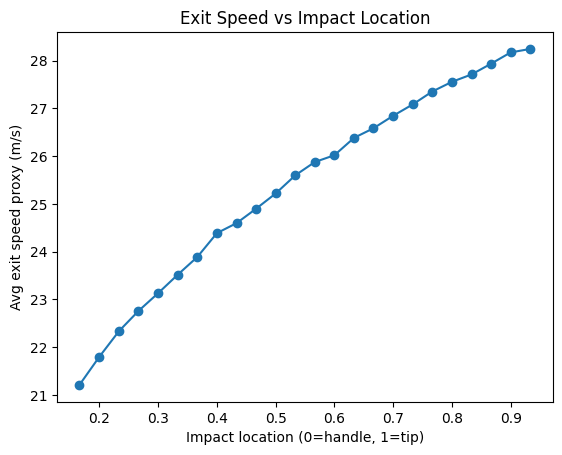

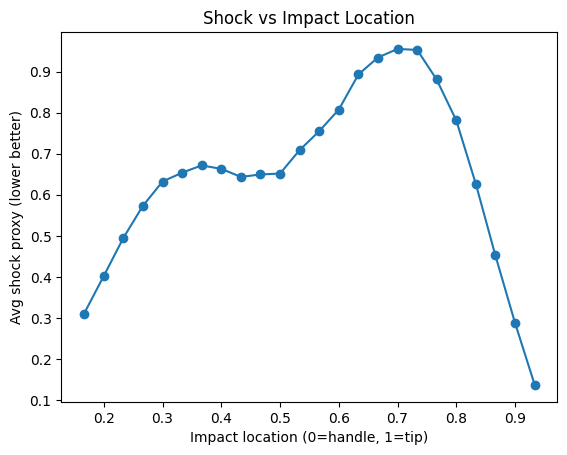

In [7]:
# Sweet spot map: impact location vs performance

bins = np.linspace(0.15, 0.95, 25)
df["x_bin"] = pd.cut(df["x_norm"], bins=bins, include_lowest=True)

g = df.groupby("x_bin", observed=False).agg({
    "v_exit": "mean",
    "shock_proxy": "mean"
}).reset_index()

x_mid = np.array([(i.left + i.right)/2 for i in g["x_bin"]])

plt.figure()
plt.plot(x_mid, g["v_exit"], marker="o")
plt.xlabel("Impact location (0=handle, 1=tip)")
plt.ylabel("Avg exit speed proxy (m/s)")
plt.title("Exit Speed vs Impact Location")
plt.show()

plt.figure()
plt.plot(x_mid, g["shock_proxy"], marker="o")
plt.xlabel("Impact location (0=handle, 1=tip)")
plt.ylabel("Avg shock proxy (lower better)")
plt.title("Shock vs Impact Location")
plt.show()

In [8]:
# Define a single “sweet spot score”

v_norm = (df["v_exit"] - df["v_exit"].min()) / (df["v_exit"].max() - df["v_exit"].min() + 1e-9)
s_norm = (df["shock_proxy"] - df["shock_proxy"].min()) / (df["shock_proxy"].max() - df["shock_proxy"].min() + 1e-9)

# score: higher is better
df["sweet_score"] = 0.65 * v_norm - 0.35 * s_norm

df[["v_exit","shock_proxy","sweet_score"]].describe()

,v_exit,shock_proxy,sweet_score
count,7000.000000,7000.000000,7000.000000
mean,25.331194,0.643122,0.183192
std,2.287591,0.233481,0.134301
min,19.466701,0.063601,-0.083821
25%,23.603265,0.503698,0.087243
50%,25.616196,0.652615,0.160145
75%,27.160717,0.795538,0.246714
max,30.447788,1.300813,0.635913


In [9]:
# Find best designs + interpret where sweet spot is

best = df.sort_values("sweet_score", ascending=False).head(15)
best[["sweet_score","v_exit","shock_proxy","m_racket","k_string","damping","x_norm"]]

,sweet_score,v_exit,shock_proxy,m_racket,k_string,damping,x_norm
1598,0.635913,30.447788,0.113395,0.338150,4149.844225,0.017111,0.946932
5702,0.624353,30.218547,0.106295,0.336307,4030.814177,0.040531,0.944162
3342,0.611803,29.888932,0.081688,0.328223,3961.887549,0.077998,0.945879
1423,0.608778,29.955504,0.106310,0.327922,4052.490455,0.077010,0.938211
1901,0.607316,30.062812,0.133933,0.329263,4092.054895,0.024381,0.940570
6467,0.605914,30.075711,0.141586,0.334040,3995.842472,0.020684,0.939215
1769,0.604424,29.972671,0.125294,0.334057,3928.285329,0.051719,0.936674
162,0.602683,30.110815,0.160353,0.335964,3998.935059,0.023539,0.934320
3606,0.598014,29.930313,0.139091,0.330829,3999.923203,0.068610,0.929980
3501,0.592114,29.529505,0.076082,0.331901,3594.068406,0.068163,0.948210


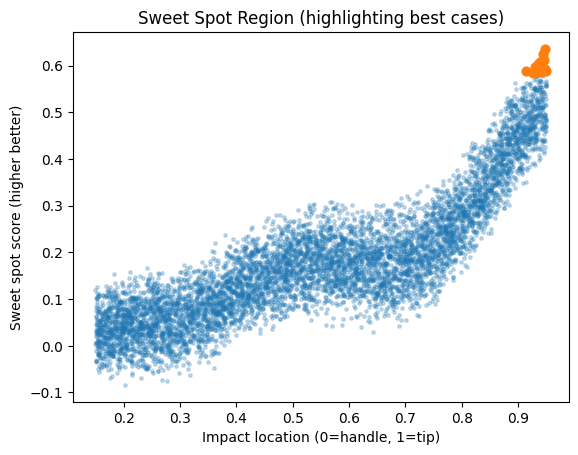

In [10]:
# Visual: where the best impacts happen

plt.figure()
plt.scatter(df["x_norm"], df["sweet_score"], s=6, alpha=0.25)
plt.scatter(best["x_norm"], best["sweet_score"], s=40)
plt.xlabel("Impact location (0=handle, 1=tip)")
plt.ylabel("Sweet spot score (higher better)")
plt.title("Sweet Spot Region (highlighting best cases)")
plt.show()

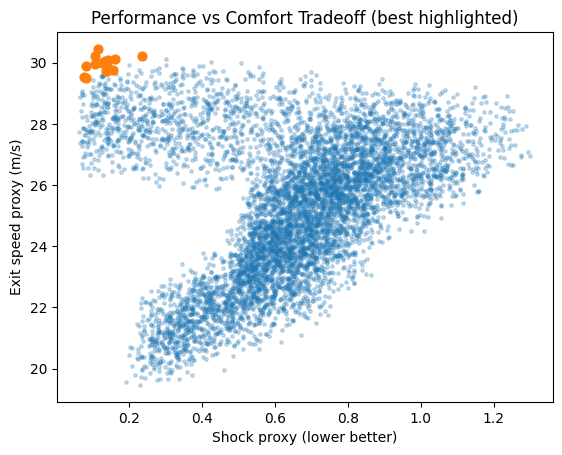

In [11]:
# Simple optimization insight: tradeoff plot (speed vs shock)

plt.figure()
plt.scatter(df["shock_proxy"], df["v_exit"], s=6, alpha=0.25)
plt.scatter(best["shock_proxy"], best["v_exit"], s=40)
plt.xlabel("Shock proxy (lower better)")
plt.ylabel("Exit speed proxy (m/s)")
plt.title("Performance vs Comfort Tradeoff (best highlighted)")
plt.show()

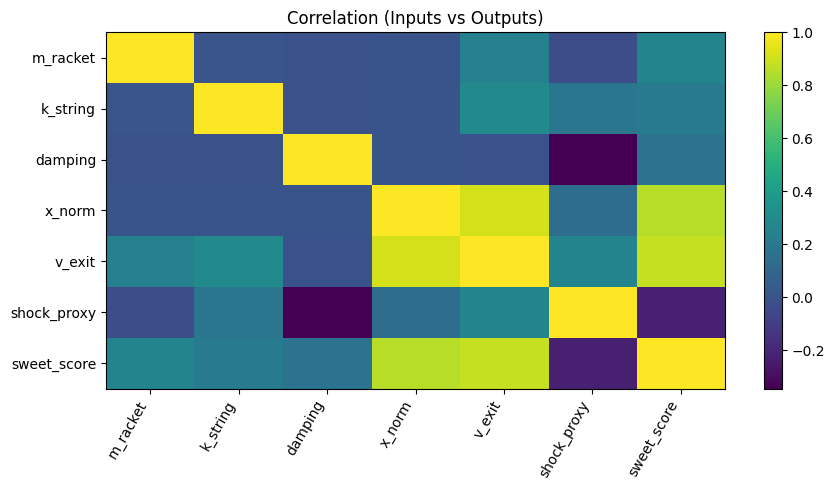

In [12]:
# What parameter matters most? (correlation view)

cols = ["m_racket","k_string","damping","x_norm","v_exit","shock_proxy","sweet_score"]
corr = df[cols].corr(numeric_only=True)

plt.figure(figsize=(9,5))
plt.imshow(corr.values, aspect="auto")
plt.xticks(range(len(cols)), cols, rotation=60, ha="right")
plt.yticks(range(len(cols)), cols)
plt.title("Correlation (Inputs vs Outputs)")
plt.colorbar()
plt.tight_layout()
plt.show()